# Linear Regression

In [2]:
using Plots, GLM, CSV, DataFrames, LinearAlgebra, Statistics, StatsBase, Distributions

### Simple linear regression using GLM

In [3]:
df = CSV.read(download("https://bit.ly/3goOAnt"), DataFrame);
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Int64,DataType
1,x,5.5,1,5.5,10,0,Int64
2,y,15.4,5,15.0,25,0,Int64


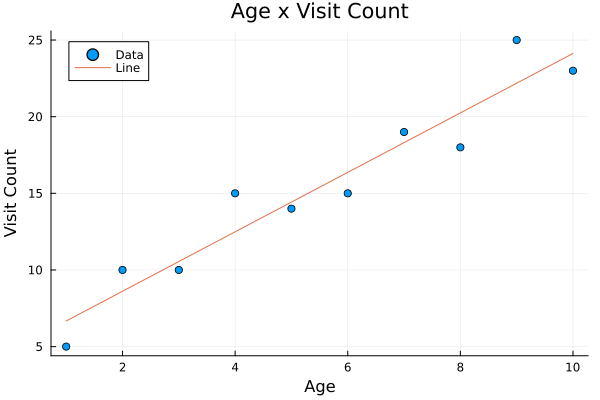

In [4]:
ols = lm(@formula(y ~ x), df);
m, b = coef(ols)[2], coef(ols)[1];
X, Y = df.x, df.y;
p1 = scatter(X, Y, label="Data");
plot!(X, m*X.+b, label="Line");
title!("Age x Visit Count");
xlabel!("Age");
ylabel!("Visit Count")

### Residuals and Squared Errors
The residual is the numeric difference between the line and the points. Points obove the line will have positive residual, while points below the line, negative. In other words it is the subtracted difference between the predicted y-values(derived from the line) and the actual y-values(that comes with the data). Another name for residuals are errors, because they reflect how wrong our line is predicting the data.

If we are fitting a line though our data points, we likely want to minimize these residuals in total so there is the least gap possible between the line and the points. We take the **sum of squares**, which simply squares each residual and sum them.

In [5]:
m, b = 1.93939, 4.73333;
points = Tuple.(eachrow(df));
sumofsquares = 0.0;

for p in points
    yactual = p[2];
    ypredict = m * p[1] + b;
    residual = yactual - ypredict;
    println("Residual -> $residual");
    residualsquared = residual^2;
    sumofsquares += residualsquared;
end

println("Sum of squared $sumofsquares");

Residual -> -1.67272
Residual -> 1.3878900000000005
Residual -> -0.5515000000000008
Residual -> 2.5091099999999997
Residual -> -0.4302799999999998
Residual -> -1.3696699999999993
Residual -> 0.6909400000000012
Residual -> -2.2484499999999983
Residual -> 2.812160000000002
Residual -> -1.1272299999999973
Sum of squared 28.096969704500005


### Finding the Best Fit Line
We now have a way to measure the quality of a given line against the data
points: the **sum of squares**. *The lower we can make that number, the better
the fit*. Now how do we find the right *m* and *b* values that create the least
sum of squares?
There are a couple of search algorithms we can employ, which try to find
the right set of values to solve a given problem. You can try a brute force
approach, generating random m and b values millions of times and choosingthe ones
that produce the least sum of squares. This will not work well
because it will take an endless amount of time to find even a decent
approximation. We will need something a little more guided. I will curate
five techniques you can use: **closed form, matrix inversion, matrix
decomposition, gradient descent, and stochastic gradient descent**. There are
other search algorithms like **hill** climbing that could be used, but we will
stick with what’s common.
#### Closed Form Equation
Only works with simple linear regression with one input. For a simple linear
regression with only one input and one output variable, here are the closed form
equations to calculate m and b:
$$m = \frac{n \sum xy - \sum x \sum y}{n\sum x^2 - \big( \sum x )^2}$$
$$b = \frac{\sum y}{n} - m\frac{\sum x}{n}$$

In [6]:
points = Tuple.(eachrow(df));

n = length(points);
m = (n * sum([p[1] * p[2] for p in points]) - sum([p[1] for p in points]) * sum([p[2] for p in points])) / (n * sum([p[1]^2 for p in points])
    - sum([p[1] for p in points])^2)
b = (sum([p[2] for p in points]) / n) - m * sum([p[1] for p in points]) / n;

println("m: $m, b: $b");

m: 1.9393939393939394, b: 4.7333333333333325


#### Inverse Matrix Techniques
We can use transposed and inverse matrices, which we covered in, to fit a linear regression. Next, we calculate a vector of coefficients b given a matrix of input variable values X and a vector of output variable values y. Without going down a rabbit hole of calculus and linear algebra proofs, here is the formula:

$$
b = \big(X^T*X \big)^{-1}*X^T*y
$$

Transpose and inverse operations are performed on the matrix $X$ and combined with matrix multiplication.

In [7]:
x = df.x;
y = df.y;

[1.9393939393939412, 4.733333333333334]


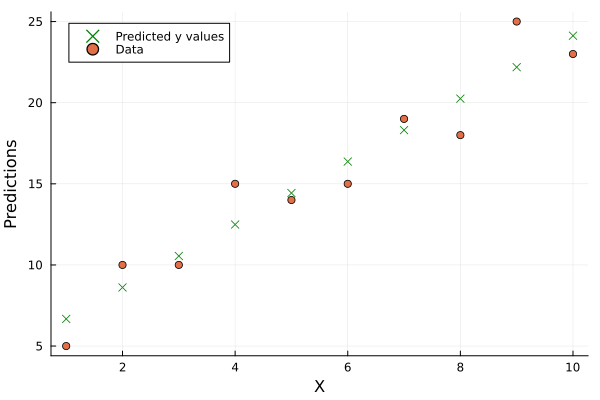

In [8]:
# horizontally stack the two vectors (x, ones)
x1 = [x ones(10)]

# calculate coefficents for slope and intercept
b = inv(x1' * x1) * x1' * y;
println(b);

# predict against y-values
ypredict = x1 * b;
scatter(x, ypredict, marker=:xcross, c=:green, label="Predicted y values", xlabel="X", ylabel="Predictions");
scatter!(x, y, label="Data")

#### Matrix Decomposition
$$
X = Q*R \\[10pt]
b = R^{-1}*Q^{T}*y
$$

In [9]:
x1 = [x ones(length(x))];
Q, R = qr(x1);
b = (inv(R) * Q') * y 

2-element Vector{Float64}:
 1.9393939393939394
 4.733333333333333

#### Gradient Descent
Gradient Descent is an optimization technique that uses derivatives and iterations to minimize/maximize a set of parameters against and objective.
Below a simple example using the function $f(x)=(x-3)^2 + 4$

In [10]:
f(x) = (x - 3)^2 + 4;
dxf(x) = 2(x - 3);

# learning rate
L = 0.001;

# number of iterations
iterations = 100_000;

# start at random x
c = rand(-15.0:15.0);

for _ in 1:iterations
    
    # get slope
    dx = dxf(c);

    # update x by subtracting the (learning rate) * (slope)
    c -= L * dx;
end
println("$c, $(f(c))");

2.999999999999889, 4.0


We can see in plot below that we had found the most plane slope in the function

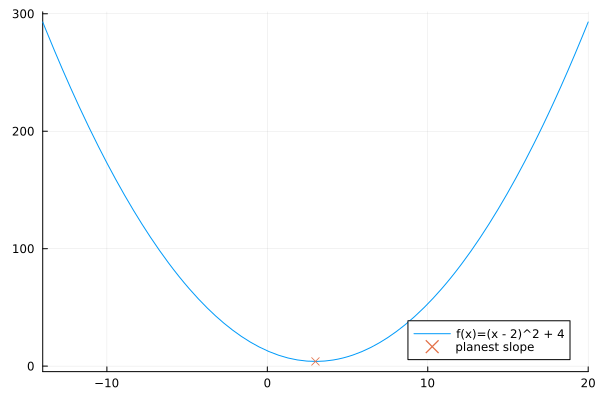

In [11]:
plot(f, xlims=(-14, 20), label="f(x)=(x - 2)^2 + 4");
scatter!([c], [f(c)], m=:xcross, label="planest slope")

#### Using gradient descent to solve linear regression

We use partial derivatives to solve $\beta_0$ and $\beta_1$ by optimizing the loss function *sum of squares*.

In [12]:
points = Tuple.(eachrow(df));
m = 0.0; 
b = 0.0;
L = 0.001;

iterations = 100_000;
n = length(points)

for _ in 1:iterations
    dm = sum(2 * p[1] * ((m * p[1] + b) - p[2]) for p in points);
    db = sum(2 * ((m * p[1] + b) - p[2]) for p in points);
    m -= L * dm;
    b -= L * db;
end

println("y = $m x + $b")

y = 1.9393939393939548 x + 4.733333333333227


#### Plotting the loss function for linear regression
$$
e(x) = \sum_{i=0}^{n}((mx_i+b)-y_i)^2 \\[10pt]
\frac{d}{dm}e(x)=\sum_{i=0}^{n}2(b + mx_i-y_i)x_i \\[10pt]
\frac{d}{db}e(x)=\sum_{i=0}^{n}(2b + 2mx_i - 2y_i)
$$

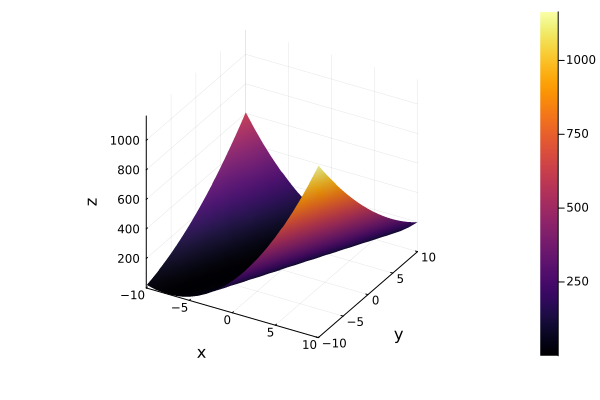

In [13]:
# for m = 1.9393939393939548 and b = 4.733333333333227
f(x, y) = sum(((m * x + b) - y)^2);
grid = -10:10;
surface(grid, grid, f, xlabel="x", ylabel="y", zlabel="z")

#### Stochastic Gradient Descent

We will unlikely use gradient descent most of the time in our work. Thats because gradient descent works in all dataset and this will not perform very well, and also it creates overfitting. Instead we will use stochastic gradient descent in a sample of our dataset.

In [14]:
# here we are using x, y as our data
x = df.x;
y = df.y;

n = nrow(df); # 10 rows

# building the model
m, b = 0.0, 0.0;
sampsize = 1; # sample size
L = .0001; # the learning rate
epochs = 1_000_000; # the number of iterations to perform gradient

for i in 1:epochs
    idx = sample(1:n, sampsize, replace=false);
    xsample = x[idx][1];
    ysample = y[idx][1];

    
    # the current predicted value of y
    ypred = m * xsample + b;
    
    # d/dm derivative of loss function
    dm = (-2 / sampsize) * sum(xsample * (ysample - ypred));
    
    # d/db derivative of loss function
    db = (-2 / sampsize) * sum(ysample - ypred);
    m = m - L * dm; # update m
    b = b - L * db; # update b
    
    # update progress
    if i % 100000 == 0
        println("$i -> $m, $b");
    end
end

println("y = $m x + $b");

100000 -> 1.9471540161518974, 4.666544740685976
200000 -> 1.9116276568436252, 4.727934607537779
300000 -> 1.9559694236331342, 4.755193404511909
400000 -> 1.9412532910949782, 4.712259623717541
500000 -> 1.9301613989002449, 4.747852447301784
600000 -> 1.9895002684101646, 4.7287148334709395
700000 -> 1.9132795379241838, 4.738515521532648
800000 -> 1.9315745255309749, 4.707073308803026
900000 -> 1.9429806244540535, 4.739274592440027
1000000 -> 1.9447330570584103, 4.740844392090575
y = 1.9447330570584103 x + 4.740844392090575


### The Correlation Coefficient

The correlation coefficient is useful for seeing if there
is a possible relationship between two variables. If there is a **strong
positive-negative** relationship, it will be *useful* in our linear regression. If
**there is not** a relationship, they may just add noise and hurt model accuracy.

2×2 Matrix{Float64}:
 1.0       0.957586
 0.957586  1.0

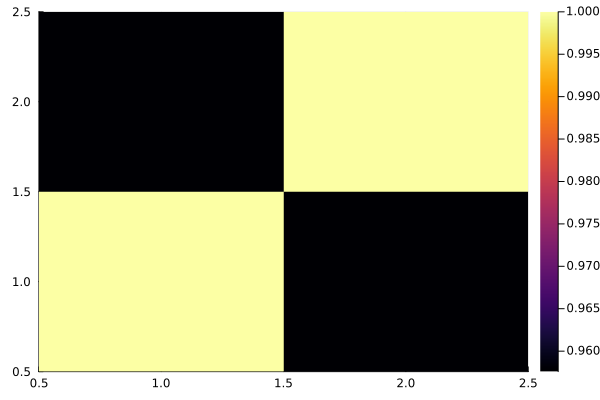

In [15]:
matrix = [x y]
cormatrix = cor(matrix); # probably Pearson's method
display(cormatrix);
heatmap(cormatrix)

#### Calculating the correlation coefficient
$$
r = \frac{n\sum xy - (\sum x)(\sum y)}{\sqrt{n\sum x^2 - (\sum x)^2}*\sqrt{n\sum y^2 - (\sum y)^2}}
$$

In [16]:
n = length(points);
numerator = n * sum(p[1]*p[2] for p in points) - (sum(p[1] for p in points) * sum(p[2] for p in points));
denominator = sqrt(n * sum(p[1]^2 for p in points) - sum(p[1] for p in points)^2) * sqrt(n * sum(p[2]^2 for p in points)
    - sum(p[2] for p in points)^2);
corr = numerator / denominator;
print(corr)

0.9575860952087218

### Statistical Significance

1 - Is my data correlation coincidental? \
2 - Is it possible I see linear relationship in my data due to random chance? \
3 - How can we be 95% sure the correlation between these two variables is significant and not coincidental?

$$
H_0 : \rho = 0\ (implies\ no\ relationship) \\[10pt]
H_1 : \rho \neq 0\ (relationship\ is\ present)
$$

In [17]:
n = 10;
tdist = TDist(10 - 1);
lowercv = quantile(tdist, .025);
uppercv = quantile(tdist, .975);

println("lower critical value: $lowercv, upper critical value: $uppercv");

lower critical value: -2.262157162798205, upper critical value: 2.2621571627982044


If our test values happens to fall outside this range of **(2.262157162798205, 2.2621571627982044)**, then we can reject our null hypothesys. To calculate the test value *t*, we need to use the following formula.

$$
t = \frac{r}{\sqrt{\frac{1-r^2}{n-2}}}
$$

In [18]:
r = corr;
testvalue = r/sqrt((1-r^2) / (n - 2));

println("TEST VALUE: $testvalue");
println("Critical Range: $lowercv <- 0 -> $uppercv");

if testvalue < lowercv || testvalue > uppercv
    println("CORRELATION PROVEN, REJECT H0");
else
    println("CORRELATION PROVEN, FAILED TO REJECT H0");
end

pvalue = 0;
# calculate p-value
if testvalue > 0
    pvalue = 1.0 - cdf(tdist, testvalue);
else
    pvalue = cdf(tdist, testvalue);
end

# two-tailed, so multiply by 2
pvalue *= 2;
println("p-value: $pvalue"); 

TEST VALUE: 9.399575927136752
Critical Range: -2.262157162798205 <- 0 -> 2.2621571627982044
CORRELATION PROVEN, REJECT H0
p-value: 5.9763270991997075e-6


so this is virtually **not coincident** and **not by chance**, as our **p-value is significant, remarkably below 0.05**. The correlation is real.

### Coefficient of Determination
Called $r^2$, the *coefficient of determination* measures how much variation in one variable is explainable by the variation of other variable. It is also the square of correlation coefficient $r$. As $r$ approaches a perfect correlation (-1, 1), $r^2$ approaches 1. A coefficient of determination of 0.916971 is interpreted as 91.69% of the variation in x is eplained by y (and vice versa), and the remaining 8.3029% is noise caused by other uncapture variables.

In [21]:
coeff = cor(df.x, df.y)^2;
println("$coeff% of variation in x is explained by y (and vice versa)");

0.916971129737087% of variation in x is explained by y (and vice versa)


### Standard Error of the Estimate
The way to measure the overall error of a linear regression, is using the **SSE**, or *sum of squared error*. We square each residual and sum them. If the $\hat{y}$ is the predicted value from the line and $y$ represents each actual y-value from the data, here is the calculation:
$$
SSE = \sum(y - \hat{y})^2 \\[10pt]
S_e = \frac{\sum (y - \hat{y})^2}{n-2}
$$

In [23]:
points = Tuple.(eachrow(df));
n = length(points);

# regression line
m = 1.939;
b = 4.733;

# calculate the standard error of the estimate
se = sqrt((sum((p[2] - (m * p[1] + b)) ^ 2 for p in points)) / (n - 2))

1.87406793500129

### Prediction Intervals
The data in a linear regression is a sample from a population. The linear regression line also has a normal distribution running along it. In fact, the mean is shifting along the line. We hope the data follows a normal distribution in a linear way. There is a confidence interval around each $y$ prediction, and this is known as prediction interval.
$$
E=t_{.025}*Se*\sqrt{1+\frac{1}{n}+\frac{n(x_0 - \bar{x})^2}{n(\sum x^2) - (\sum x)^2}}{}
$$

In [25]:
points = Tuple.(eachrow(df));
n = length(points);
# Linear Regression Line
m = 1.939;
b = 4.733;

# Calculate Prediction Interval for x = 8.5
x0 = 8.5;
xmean = sum(p[1] for p in points) / n;
tvalue = quantile(TDist(n - 2), .975);
stderror = sqrt(sum((p[2] - (m * p[1] + b))^2 for p in points) / (n - 2));
moferror = tvalue * stderror * sqrt(1 + (1/n) + (n * (x0 - xmean)^2) / (n * sum(p[1]^2 for p in points) - sum(p[1] for p in points)^2));

predy = m * x0 + b;
println(predy - moferror, ", ", predy + moferror);

16.46251687560351, 25.966483124396493
